# Loading Data

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split


In [20]:
# Creating train and test data sets (from GitHub, no need to add it manually)
url = 'https://raw.githubusercontent.com/AnastasiaDv491/AA-datasets/main/train.csv'

full_data_set = pd.read_csv(url)

target_price = full_data_set['target']
feature_full = full_data_set.drop('target', axis=1)
feature_train, feature_test, target_train, target_test = train_test_split(feature_full, target_price, random_state=1)

matrix_train = feature_train.join(target_train,on="property_id")


In [ ]:

full_data_set.head()
full_data_set.tail()


# Exploratory Data Analysis (EDA)

In [ ]:
full_data_set.shape     ##(6495, 55)

## looking at a few measures

full_data_set.describe()

full_data_set.nunique()

full_data_set['host_response_time'].unique()

full_data_set.isnull().sum()  ## quite a few variables can be dropped



In [ ]:
## variables that need to be dropped, shall be commented out below

df = full_data_set[['property_id', 'property_name', 'property_summary', 'property_space',
       'property_desc', 'property_neighborhood', 'property_notes',
       'property_transit', 'property_access', 'property_interaction',
       'property_rules', 'property_zipcode', 'property_lat', 'property_lon',
       'property_type', 'property_room_type', 'property_max_guests',
       'property_bathrooms', 'property_bedrooms', 'property_beds',
       'property_bed_type', 'property_amenities', 'property_sqfeet',
       'property_scraped_at', 'property_last_updated', 'host_id', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_nr_listings', 'host_nr_listings_total',
       'host_verified', 'booking_price_covers', 'booking_min_nights',
       'booking_max_nights', 'booking_availability_30',
       'booking_availability_60', 'booking_availability_90',
       'booking_availability_365', 'booking_cancel_policy', 'reviews_num',
       'reviews_first', 'reviews_last', 'reviews_rating', 'reviews_acc',
       'reviews_cleanliness', 'reviews_checkin', 'reviews_communication',
       'reviews_location', 'reviews_value', 'reviews_per_month', 'extra',
       'target']].copy()

df.head()



<AxesSubplot:>

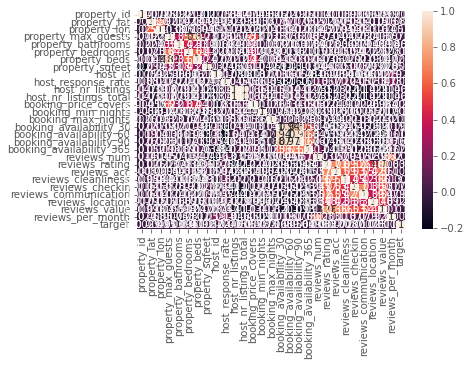

In [ ]:

## Relationship analysis

correlation = df.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)

In [ ]:
df.dtypes

From here on we will proceed with only the train features in order to avoid any data spillage

## Autoviz

[Documentation](https://www.kaggle.com/general/233832)

In [ ]:
! pip install autoviz
# importing Autoviz class
from autoviz.AutoViz_Class import AutoViz_Class #Instantiate the AutoViz class
AV = AutoViz_Class()

In [ ]:
eda=AV.AutoViz(filename="",dfte=matrix_train)

## Ydata-profling (Former pandas-profling)

[Documentation](https://ydata-profiling.ydata.ai/docs/master/pages/getting_started/quickstart.html#using-inside-jupyter-notebooks)

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
profile = ProfileReport(matrix_train,title="Pandas Profiling Report")

### Widgets

In [ ]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### HTML

In [ ]:
profile.to_notebook_iframe()
profile.to_file("Ydata_report.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_file("Ydata_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<h2> Pipeline for feature processing </h2>

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer

df = feature_train.copy()

def isMissing(df, col, new_col):
  df[new_col] = np.where(df[col].isna(), 1, 0)
  return df


class toLowerCase():
  def __init__(self, columns=None):
    self.columns = columns
    
  def fit(self, X, y=None):
      return self
  
  def transform(self,X, y= None):
    X = X.apply(lambda x: x.str.lower() if x.dtype=='object' else x)

    return X

def SummaryMissing(df, col, new_col):
  
  df[new_col] = np.where(df[col].str.split().str.len() == 1, 1, 0)
  df[new_col] = np.where(df[col].isna(), 1, 0)   
  return df
  
def splitCountWords(df, cols):
  for col in cols:
    df[col] = df[col].str.replace('\d+', '').replace('[^\w\s]',' ')
    df[col] = df[col].str.split().str.len()
  return df

def columnDropperTransformer(df, cols):
  df = df.drop(cols, axis=1)
  return df
    
def featureGrouping(df, col):
  threshold_percent = 3

  series = pd.value_counts(df['property_type'])
  mask = (series / series.sum() * 100).lt(threshold_percent)

  df= df.assign(col = np.where(df[col].isin(series[mask].index),'Other', df[col]))
  return df 

def replaceWithMode(df, cols):
  for col in cols:
      df[col] = df[col].fillna(df[col].mode()[0])
  return df

def replacewithZero(df, cols):
  for col in cols:
    df[col] = df[col].fillna(0)
  return df

def removeSpaces(df, cols):
  for col in cols:
    df[col] = df[col].replace(' ', '')
  return df

def BathroomsCount(df, col,new_col):
  df[new_col]= 'One'
  df.loc[(df[col] < 1) , new_col] = 'None'
  df.loc[(df[col] > 1), new_col] = 'More than one'

  df = df.drop([col], axis = 1)
  return df

def NumToCategory(df, cols,new_cols):
  for col, new_col in zip(cols, new_cols):
    conditions = [
      (df[col]==1),
      (df[col]==2),
      (df[col]==3),
      (df[col]>3)
    ]
    choices = ['One', 'Two', 'Three', 'More than three']
    df[new_col] = np.select(conditions, choices) 
  return df

def reviewRecoding(df, cols, new_cols):
  for col, new_col in zip(cols, new_cols):
    df[new_col] = df[col].fillna("Average") # average
    df.loc[(df[col] == 5) , new_col] = 'Average'
    df.loc[(df[col] < 5) , new_col] = 'Bad'
    df.loc[(df[col] > 5), new_col] = 'Good'
    df = df.drop([col], axis = 1)
  return df

def change_datetime_format(df,cols):
  for col in cols:
    df[col] = pd.to_datetime(df[col])
  return df

def add_scrapped_weekday(df,cols,new_cols):
  df[new_cols] = df[cols].dt.weekday
  return df

def last_updated_wrap(df,col,new_col):
  def last_updated_conversion(update_var:str):
    # 3 Buckets evenly distributed based on train, 2 for > 3 months, 0 for updated yesterday/today
    if "never" in update_var:
      return "3 months or more"
    elif "month" in update_var:
      if int(update_var.split(" ")[0])>=3:
        return "3 months or more"
      else:
        return "1 week to 3 months"
    elif "week" in update_var:
      return "1 week to 3 months"
    else: # This catches yesterday etc. is actually equivalent to "day" in update_var
      return "Within days"
  df[new_col] = [last_updated_conversion(x) for x in df[col]] 
  df = df.drop([col], axis = 1) # Dropping old column
  return df

def splitOnComma(df, col):
  df[col] =  df[col].str.split(', ').str.len()
  return df

# #TODO: you have to include those columns as arguments you pass to the function. then you pass teh original names of the cols to the function transformer

def host_since_transform(df,col):
  df[col] = df[col].fillna(df[col].mean()) # Simply imputing with mean, only had 1 NA anyways
  df['host_since_scraped'] = df['property_scraped_at']-df['host_since']
  df['host_since_scraped'] = df['host_since_scraped'].dt.days.astype('int16')
  df = df.drop(['host_since'], axis = 1) # Dropping old columns
  return df 

def missing_cat(df,col):
  # Just adds "Missing" as categorical value
  df[col]= df[col].fillna(value="No_requests")
  return df

def missing_to_100(df,col):
  df[col]=df[col].fillna(value=100)
  return df

def listing_number_transform(df,col,new_col):
  df[col]=df[col].fillna(value=1)
  df.loc[(df[col] <= 1) , new_col] = 'One or less'
  df.loc[(df[col] > 1) & (df[col] <=3), new_col] = 'Two to Three'
  df.loc[(df[col] > 3), new_col] = 'More than 3'
  df = df.drop([col], axis = 1)
  return df 

def min_nights_transform(df,col):
  df = df[df[col]<30]
  return df

def max_nights_transform(df,col):
  df.loc[df[col] >60, col] = 60
  return df

def booking_availability_transform(df,col):
  df[col] = df[col]-df['booking_availability_90']
  df['booking_availability_90'] = df['booking_availability_90'] - df['booking_availability_60']
  df['booking_availability_60'] = df['booking_availability_60']- df['booking_availability_30']
  return df

#TODO: add loop for the function below

def reviews_date_transform(df,cols,new_cols):
  for cols,new_cols in zip(cols,new_cols):
   df[new_cols] = (df['property_scraped_at'] -df[cols]).dt.days.astype('int16')
   df = df.drop([cols], axis = 1) # Dropping old columns
  return df

# col_trans = ColumnTransformer(
#    [('power_trans', PowerTransformer(),['property_amenities', 'reviews_num']),
#     ('lg', FunctionTransformer(np.log),['reviews_per_month'])], remainder='passthrough')



In [22]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(
     steps=[
        ('columnDropper', FunctionTransformer(columnDropperTransformer, kw_args={'cols':['property_id','property_space','property_desc','property_neighborhood','property_notes','property_access',
                                     "property_interaction","property_rules","host_location","host_about","host_id", 'property_transit', 'property_lon', 'property_lat','host_nr_listings_total']})),
        # Drops min nights outliers
        ("min_nights_transform",FunctionTransformer(min_nights_transform,kw_args={'col':'booking_min_nights'})),
    
        ("change_datetime_format", FunctionTransformer(change_datetime_format,kw_args={'cols':['property_scraped_at','host_since','reviews_first','reviews_last']})),
        ("summaryMissing", FunctionTransformer(SummaryMissing, kw_args={'col':'property_summary','new_col':'property_summary_miss'})),
        ("missing_cat",FunctionTransformer(missing_cat,kw_args={'col':'host_response_time'})),
        ("missing_to_100",FunctionTransformer(missing_to_100,kw_args={'col':'host_response_rate'})),
        ("booking_availability_transform", FunctionTransformer(booking_availability_transform,kw_args={'col':'booking_availability_365'})),
        
        ("add_scrapped_weekday",FunctionTransformer(add_scrapped_weekday,kw_args={'cols':'property_scraped_at','new_cols':'scraped_weekday'})),
        ("last_updated_wrap",FunctionTransformer(last_updated_wrap,kw_args={'col':'property_last_updated','new_col':'property_last_updated_bucket'})),
        ("listing_number_transform", FunctionTransformer(listing_number_transform,kw_args={'col':'host_nr_listings','new_col':'host_nr_listings_cat'})),
        ('splitOnComma', FunctionTransformer(splitOnComma, kw_args={'col':'property_amenities'})),
        # # replacing missing with mode
        ("replaceWithMode", FunctionTransformer(replaceWithMode, kw_args={'cols': ['property_zipcode', 'property_bathrooms', 'reviews_per_month',
                                                                                   'host_since','reviews_first','reviews_last','reviews_rating','reviews_acc']})),
        ('removeSpaces', FunctionTransformer(removeSpaces, kw_args={'cols': ['property_zipcode']}))  ,                                                                         
        ("max_nights_transform", FunctionTransformer(max_nights_transform,kw_args={'col':'booking_max_nights'})),
        # # replacing missing with zero
        ('replaceWithZero', FunctionTransformer(replacewithZero, kw_args ={'cols':['property_beds', 'property_bedrooms']})),
        ("miss",FunctionTransformer(isMissing, kw_args = {'col' :['property_name'],'new_col':['property_name_miss']})),
        ("lowercase", toLowerCase()),
        ('splitCount', FunctionTransformer(splitCountWords,kw_args={'cols':['property_name', 'property_summary','host_verified']})),
        ('propertyRegrouping', FunctionTransformer(featureGrouping, kw_args = {'col':'property_type'})),
        ('BathroomsCount',FunctionTransformer(BathroomsCount, kw_args ={'col':'property_bathrooms', 'new_col':'property_bathrooms_cat'})),
        # ('powerTransform', col_trans), #TODO: fix the bug 
        # Only run after scrapped_date functions
        ('host_since_transform',FunctionTransformer(host_since_transform,kw_args={'col':'host_since'})),
         ('reviews_date_transform',FunctionTransformer(reviews_date_transform,kw_args={'cols':['reviews_first','reviews_last'],'new_cols':['reviews_first_since_scraped',
                                                                                                                                           'reviews_last_since_scraped']})),
        ('numToCategory', FunctionTransformer(NumToCategory, kw_args={'cols':['property_beds','property_bedrooms'], 'new_cols':['propety_beds_cat', 'property_bedrooms_cat']})),
        ('reviewRecoding', FunctionTransformer(reviewRecoding, kw_args={'cols':['reviews_cleanliness','reviews_checkin','reviews_location','reviews_communication','reviews_value'], 'new_cols':[
    'reviews_cleanliness_n','reviews_checkin_n','reviews_location_n','reviews_communication_n','reviews_value_n']
        }))
    ]
)
df= pipe.fit_transform(df)
df

C:\Users\svnel\AppData\Local\Temp\ipykernel_33304\1974609540.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('\d+', '').replace('[^\w\s]',' ')


,property_name,property_summary,property_zipcode,property_type,property_room_type,property_max_guests,property_bedrooms,property_beds,property_bed_type,property_amenities,...,host_since_scraped,reviews_first_since_scraped,reviews_last_since_scraped,propety_beds_cat,property_bedrooms_cat,reviews_cleanliness_n,reviews_checkin_n,reviews_location_n,reviews_communication_n,reviews_value_n
4337,10.0,40.0,1080,apartment,private room,2,1.0,1.0,real bed,12.0,...,1642,179,179,One,One,Good,Good,Good,Good,Good
3473,2.0,38.0,1050,apartment,entire home/apt,2,1.0,2.0,real bed,15.0,...,733,385,21,Two,One,Good,Good,Good,Good,Good
6133,5.0,NaN,1060,house,private room,2,1.0,1.0,real bed,9.0,...,1428,688,688,One,One,Good,Good,Good,Good,Good
40,5.0,32.0,1210,apartment,entire home/apt,2,1.0,1.0,real bed,11.0,...,1268,1146,22,One,One,Good,Good,Good,Good,Good
3499,4.0,56.0,1000,apartment,entire home/apt,2,0.0,1.0,real bed,14.0,...,729,181,181,One,0,Average,Average,Average,Average,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,7.0,38.0,1040,apartment,private room,2,1.0,1.0,real bed,14.0,...,8,3,3,One,One,Good,Good,Good,Good,Good
5192,5.0,46.0,1000,house,entire home/apt,2,0.0,2.0,real bed,18.0,...,1544,128,8,Two,0,Average,Average,Average,Average,Average
3980,4.0,39.0,1050,apartment,entire home/apt,5,0.0,3.0,real bed,8.0,...,678,127,7,Three,0,Average,Average,Average,Average,Average
235,5.0,40.0,1210,apartment,private room,1,1.0,1.0,real bed,8.0,...,1241,128,8,One,One,Average,Average,Average,Average,Average


In [23]:
# Checking for NaNs in df
for cols in df.columns.values:   
    if df[cols].isna().sum()>0:
        print(cols)

property_name
property_summary
property_amenities
property_sqfeet
extra


In [119]:
df = feature_train.copy()
def missing_to_100(df,col):
  df[col]=df[col].fillna(value=100)

missing_to_100(df, 'host_response_rate')
df

,property_id,property_name,property_summary,property_space,property_desc,property_neighborhood,property_notes,property_transit,property_access,property_interaction,...,reviews_last,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month,extra
4337,4342,Quiet and cosy space in the heart of the city.,Our second bedroom is an ideal base to explore...,NaN,Our second bedroom is an ideal base to explore...,NaN,NaN,NaN,NaN,NaN,...,2016-11-11,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.17,"Host Has Profile Pic, Host Identity Verified, ..."
3473,3478,Charming Duplex,Charming duplex in one of the liveliest areas ...,"Last floor of a ""maison du metre"" with beauti...",Charming duplex in one of the liveliest areas ...,NaN,NaN,NaN,NaN,NaN,...,2017-04-17,90.0,9.0,9.0,10.0,10.0,8.0,9.0,0.39,"Host Has Profile Pic, Host Identity Verified"
6133,6139,Lovely Room in Saint Gilles,NaN,Room available on the first floor of a typical...,Room available on the first floor of a typical...,NaN,NaN,NaN,You can use the kitchen the living room,NaN,...,2015-06-21,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.04,"Host Has Profile Pic, Host Identity Verified, ..."
40,42,Furnished loft in Brussels City,Lovely furnished loft under the roof of an aut...,"Living room / dining room, fully equipped kitc...",Lovely furnished loft under the roof of an aut...,NaN,NaN,NaN,"Free access to all apartment including towels,...",NaN,...,2017-04-17,93.0,10.0,9.0,10.0,10.0,9.0,9.0,3.35,"Host Has Profile Pic, Host Identity Verified, ..."
3499,3504,Nice bright studio apartment,You’ll love my place because of the light and ...,NaN,You’ll love my place because of the light and ...,NaN,NaN,NaN,NaN,NaN,...,2016-11-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16,"Host Has Profile Pic, Is Location Exact"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,908,Belle chambre à Etterbeek proche quartier Euro...,"Au 2ème étage sans ascenseur, bel appartement ...",NaN,"Au 2ème étage sans ascenseur, bel appartement ...",NaN,NaN,NaN,NaN,NaN,...,2017-05-06,80.0,8.0,10.0,10.0,10.0,10.0,10.0,1.00,"Host Has Profile Pic, Is Location Exact, Insta..."
5192,5198,Studio duplex in historical center,Arty and cosy. Light flat on 3rd floor (no li...,Le charme d'une maison typique du 19ème siècle...,Arty and cosy. Light flat on 3rd floor (no li...,You have all you need in the aera. Walking dis...,Gay friendly,Very convenient. Subway station : M° Annessen...,"Washing machine, iron, vacum cleaner",I am a medecine doctor and work from 09:00 to ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Host Has Profile Pic, Host Identity Verified, ..."
3980,3985,Quiet cocoon in Ixelles!,"Bright and quiet flat close to avenue Louise, ...","one living room with separated room area, bath...","Bright and quiet flat close to avenue Louise, ...",NaN,NaN,8 minutes walk from metro porte de Namur or fr...,all the flat,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Host Has Profile Pic
235,237,Petine chambre sur le jardin,Chambre petite mais confortable avec un accès ...,L'ambiance de la maison est très vivante car n...,Chambre petite mais confortable avec un accès ...,Le quartier est calme avec toutes les commodit...,NaN,"La maison est proche du centre, près du parc r...",Les voyageurs ont accès aux pièces en commun. ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Host Has Profile Pic, Is Location Exact, Insta..."


In [ ]:
eda=AV.AutoViz(filename="",dfte=df) # check

<h3> Correlations </h3>

In [ ]:
import missingno as msno
%matplotlib inline
msno.heatmap(df)

In [ ]:
msno.dendrogram(df)

Fitting model

In [ ]:
from sklearn.linear_model import LinearRegression


# Create and fit the model
model = LinearRegression().fit(df, target_train)

# Predict on new data

predictions = model.predict(target_test)

# Print the model coefficients and predictions
print("Model coefficients:", model.coef_)
print("Predictions:", predictions)

In [ ]:
#df.isin(['11 20']).any()

#df['property_zipcode']

#print(df['property_zipcode'].where(isinstance(df['property_zipcode'],int)))

no_integer_rows = df['property_zipcode'].apply(pd.to_numeric,errors="coerce").isna() 
print(df[noìnteger_rows])

print(pd.to_numeric(df['property_zipcode'], errors='coerce').notnull())

print(feature)

# Creation of test data set

can use the pipeline above to do so @jef